## Install packages

In [ ]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("GenomicAlignments")

In [98]:
devtools::install_github("iaaka/visutils")

Skipping 1 packages not available: GenomicAlignments



✔  checking for file ‘/tmp/Rtmp77kFuD/remotes189da2d981d/iaaka-visutils-a9219eb/DESCRIPTION’ (408ms)
─  preparing ‘visutils’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘visutils_0.0.0.9000.tar.gz’
   


Installing package into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)



In [99]:
library(visutils)
library(Seurat)

## Download public dataset from 10x website

In [5]:
loadVisiumFrom10x("https://cf.10xgenomics.com/samples/spatial-exp/1.3.0","Visium_Mouse_Olfactory_Bulb",outdir="data")

load all spots (suppress filtering)

In [4]:
mob = myLoad10X_Spatial('data/Visium_Mouse_Olfactory_Bulb/',filter.matrix = FALSE,ens_id = FALSE)

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”


### Load spaceranger clusters

In [5]:
cl = read.csv('data/Visium_Mouse_Olfactory_Bulb/analysis/clustering/graphclust/clusters.csv',row.names = 1)
mob$clusters = as.character(cl[colnames(mob),1])
table(mob$clusters,useNA = 'always')


   1    2    3    4    5    6    7 <NA> 
 262  185  172  161  153  131  121 3807 

__plotVisium is the main plot function in visutils. I'll make three plots__ <br>
1. Total UMI across all spots in log scale. Spot size is also proportional to log(UMI). RNA-fingerprint clearly matches H&E image. There are some RNA in out-of-tissue spots
2. Red spots show auto-detected tissue
3. Spaceranger clusters. plotVisium uses categorical coloring since mob$clusters is character

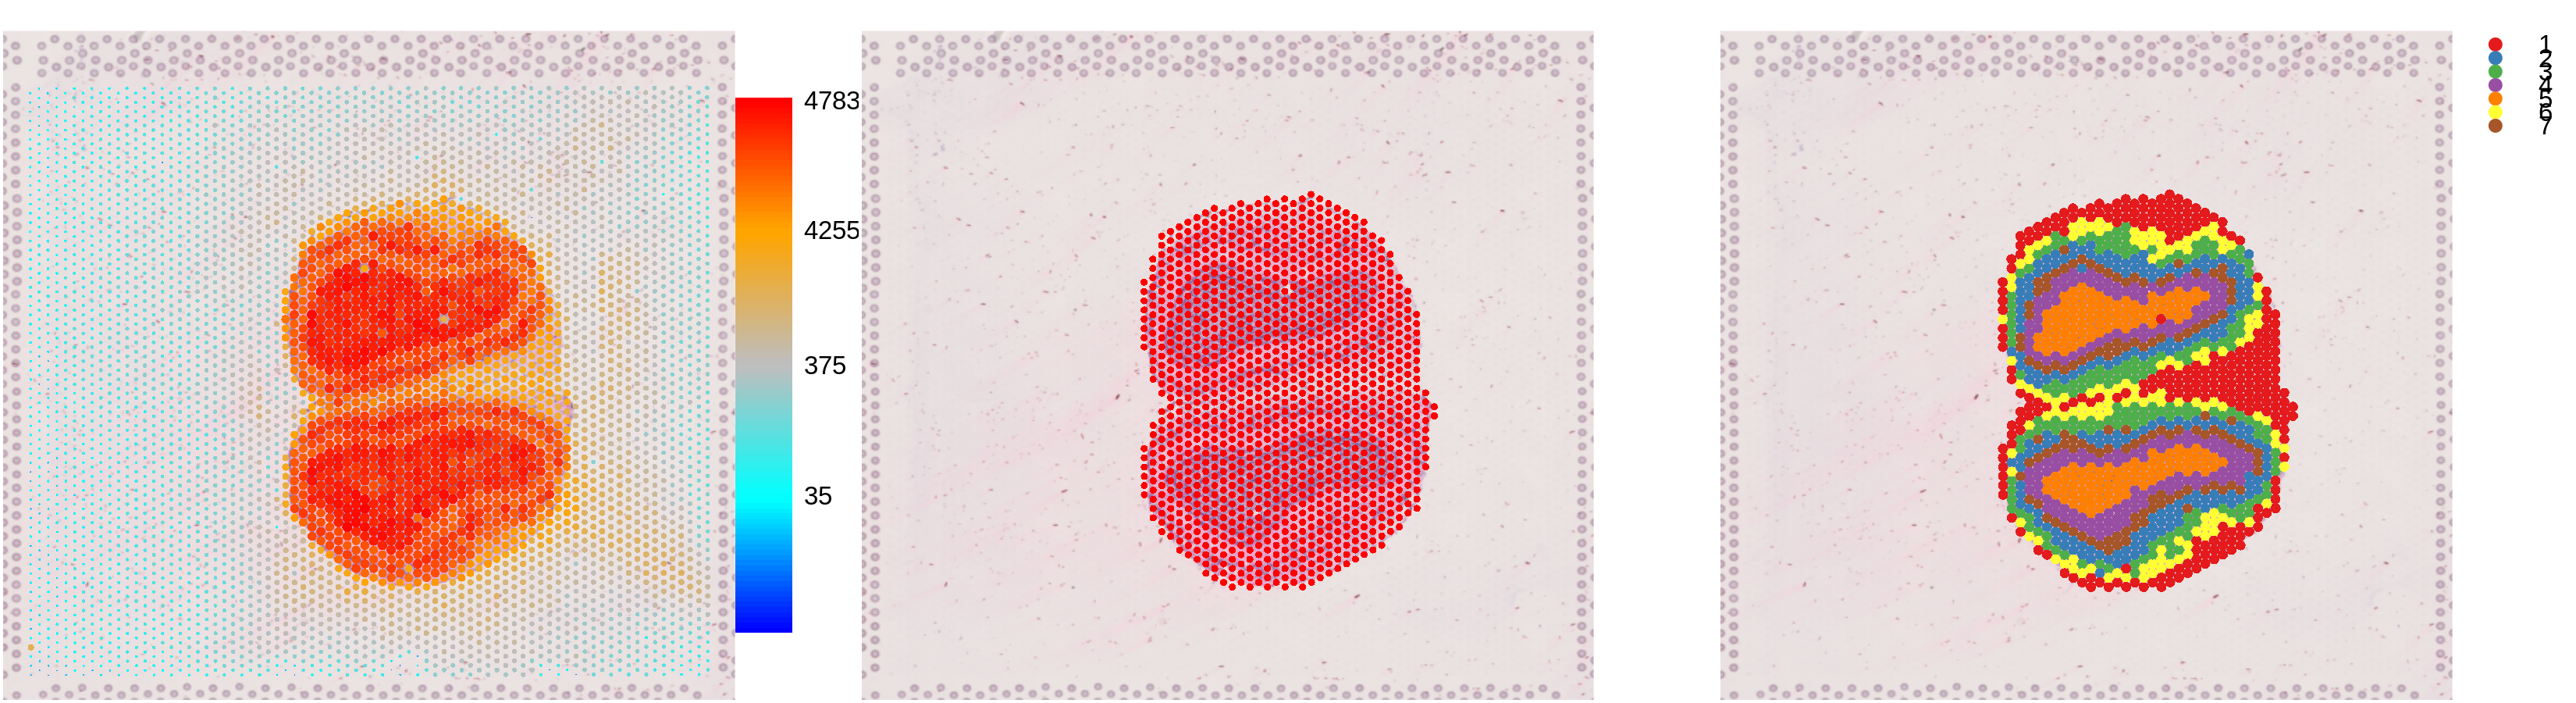

In [9]:
options(repr.plot.width = 11, repr.plot.height = 3, repr.plot.res = 300)
par(mfrow=c(1,3),mar=c(0.1,0.1,1,4),bty='n')
plotVisium(mob,mob$nCount_Spatial,zfun=log1p,cex=scaleTo(log1p(mob$nCount_Spatial)))
plotVisium(mob,'red',cex=mob$is.tissue*0.7)
plotVisium(mob,mob$clusters)

Axis are now shown by defualt, but it can be changed by xaxt/yaxt parameters. xlim/ylim can be used to crop image, spot.filter allows to subset spots to be shown. Image autocroped to visible spots.

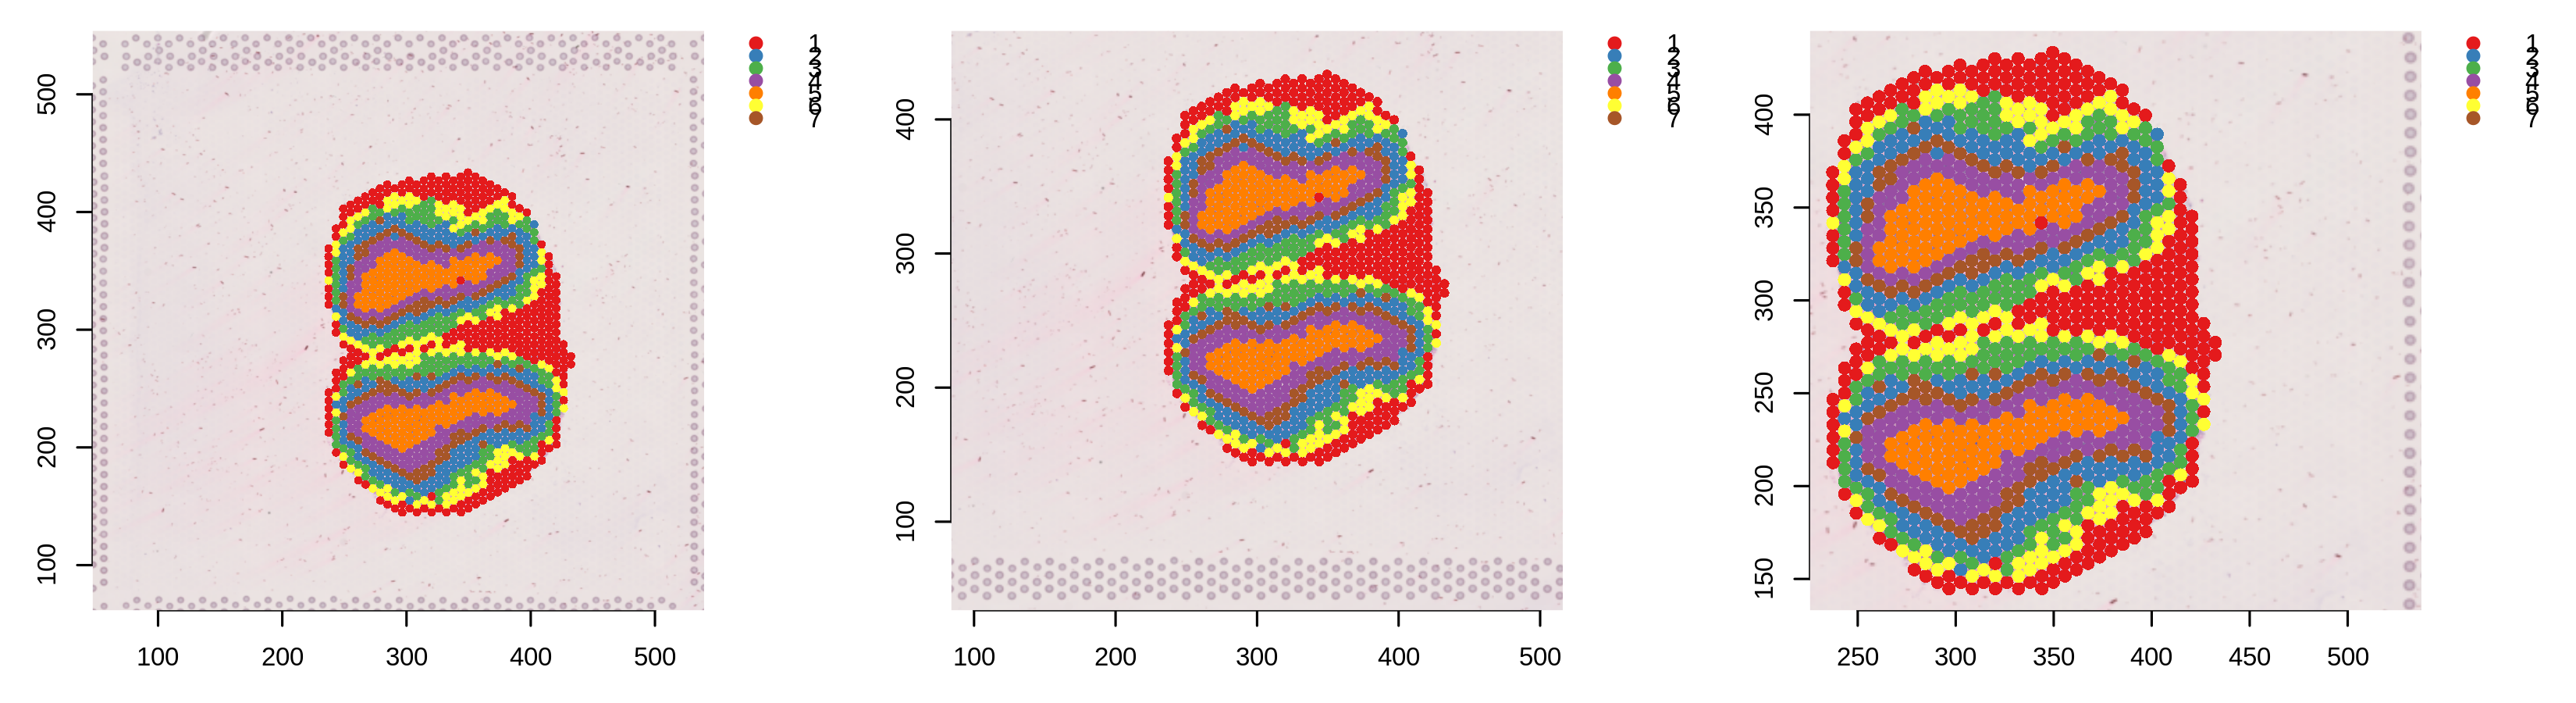

In [10]:
par(mfrow=c(1,3),mar=c(3,3,1,5),bty='n')
plotVisium(mob,mob$clusters,xaxt='s',yaxt='s')
plotVisium(mob,mob$clusters,xaxt='s',yaxt='s',xlim=c(100,500),ylim=c(50,450))
plotVisium(mob,mob$clusters,xaxt='s',yaxt='s',spot.filter = mob$is.tissue==1)

Visium images frequently have low contrast/brightnes, enhanceImage can help. If cex (spot size) is zero, then spots are not shown.

In [11]:
image = mob@images$slice1@image

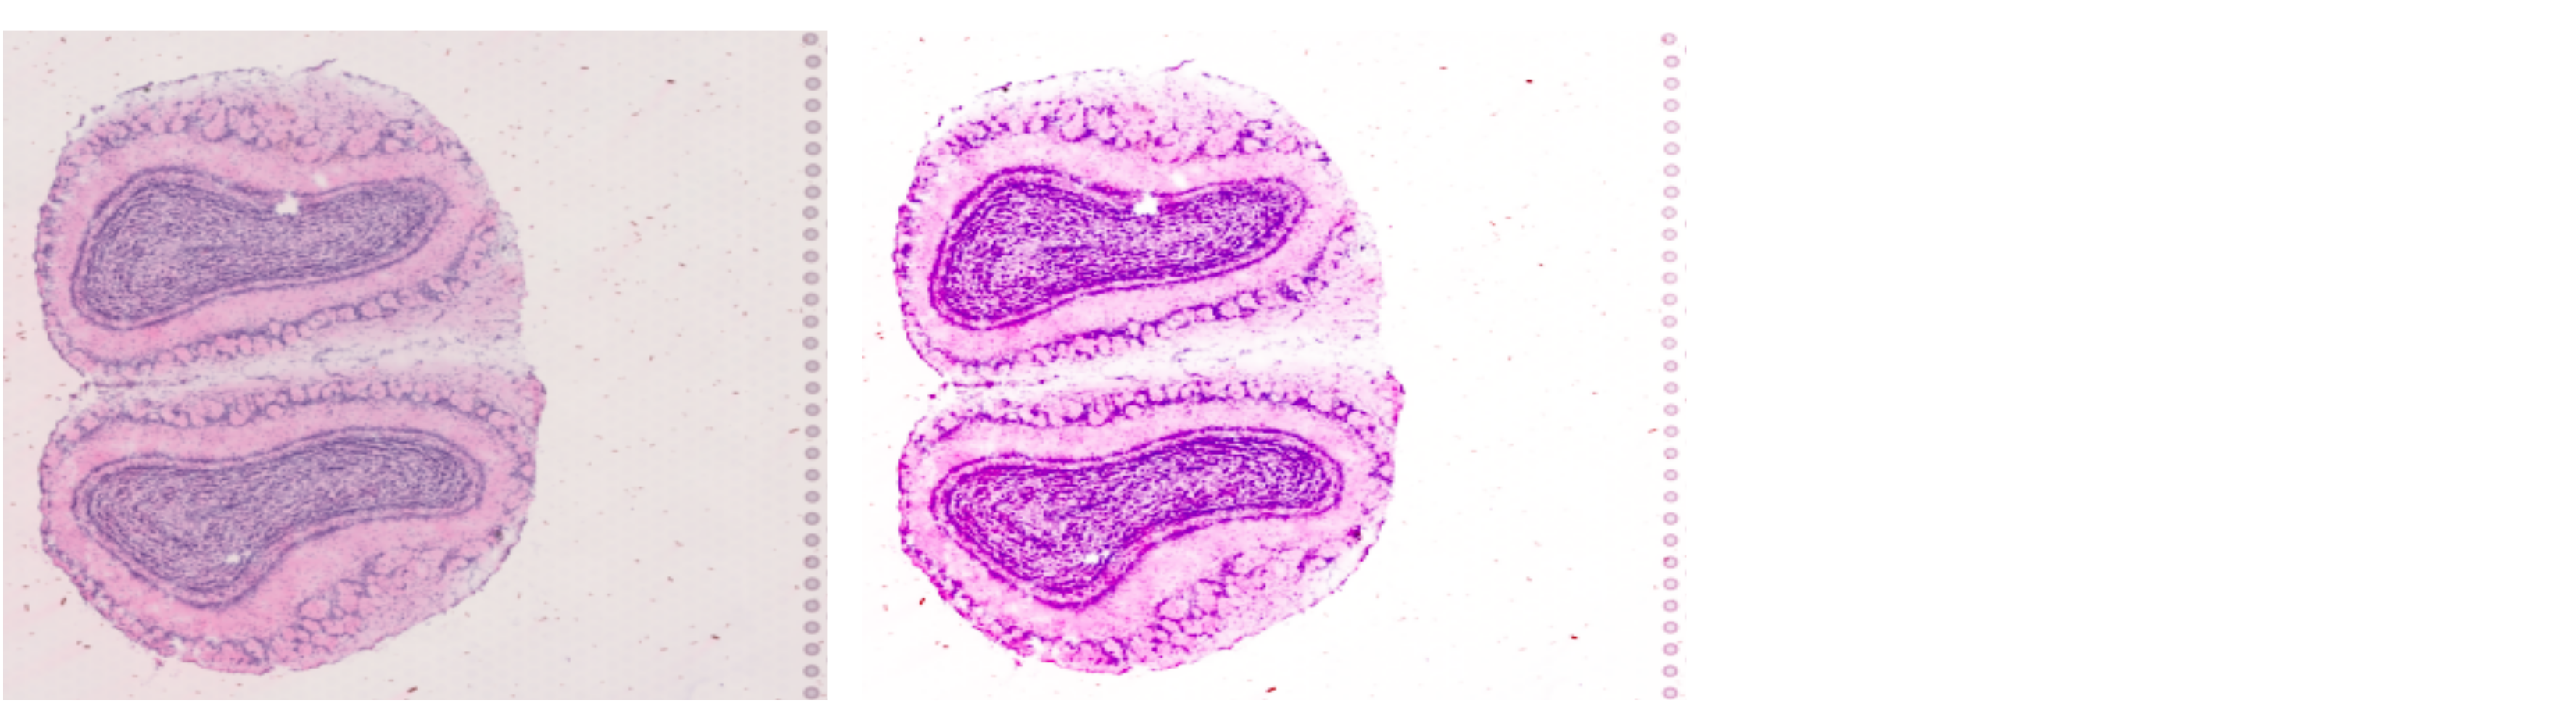

In [12]:
par(mfrow=c(1,3),mar=c(0.1,0.1,1,1),bty='n')
mob@images$slice1@image = image
plotVisium(mob,mob$clusters,cex=0,plot.legend = F,spot.filter = mob$is.tissue==1)
mob@images$slice1@image = enhanceImage(image)
plotVisium(mob,mob$clusters,cex=0,plot.legend = F,spot.filter = mob$is.tissue==1)

H&E image is hardly visible under spots, so sometime it is reasonable to not show it. In this case hex representation can be usefull

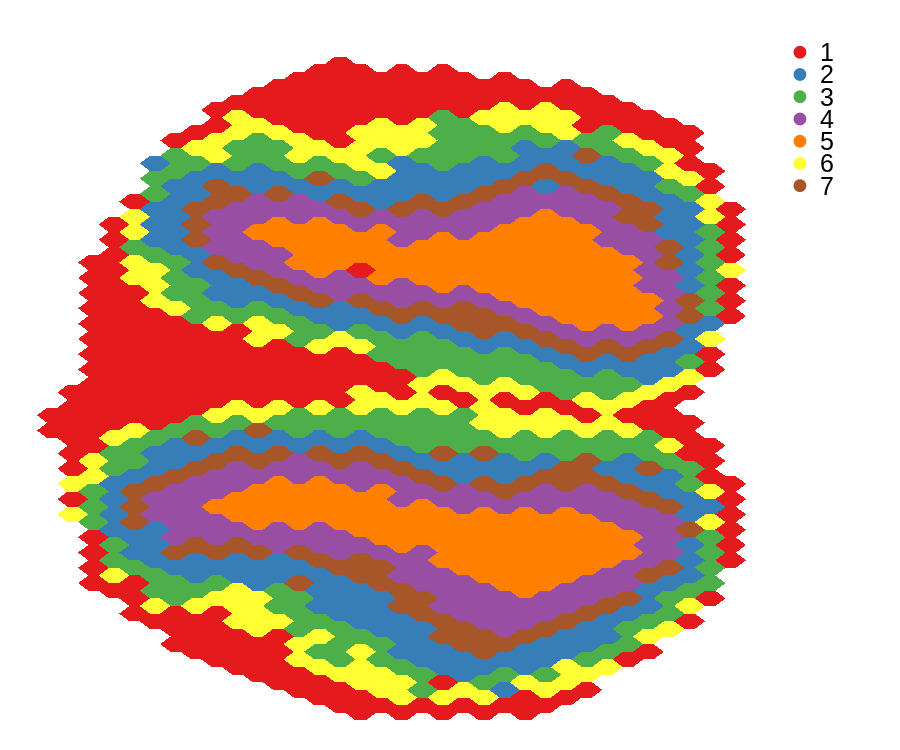

In [13]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 150)
par(mar=c(0.1,0.1,1,4),bty='n')
plotVisium(mob,mob$clusters,type='hex',spot.filter = mob$is.tissue==1)

Subset tissue spots and make clustering/umap

In [14]:
mob.all = mob

In [ ]:
mob = mod.all[,mod.all$is.tissue==1]
mob = NormalizeData(mob)
mob = FindVariableFeatures(mob)
mob = ScaleData(mob, features = rownames(mob))
mob = RunPCA(mob, features = VariableFeatures(mob))
mob = FindNeighbors(mob)
mob = FindClusters(mob)
mob = RunUMAP(mob,dims = 1:50)

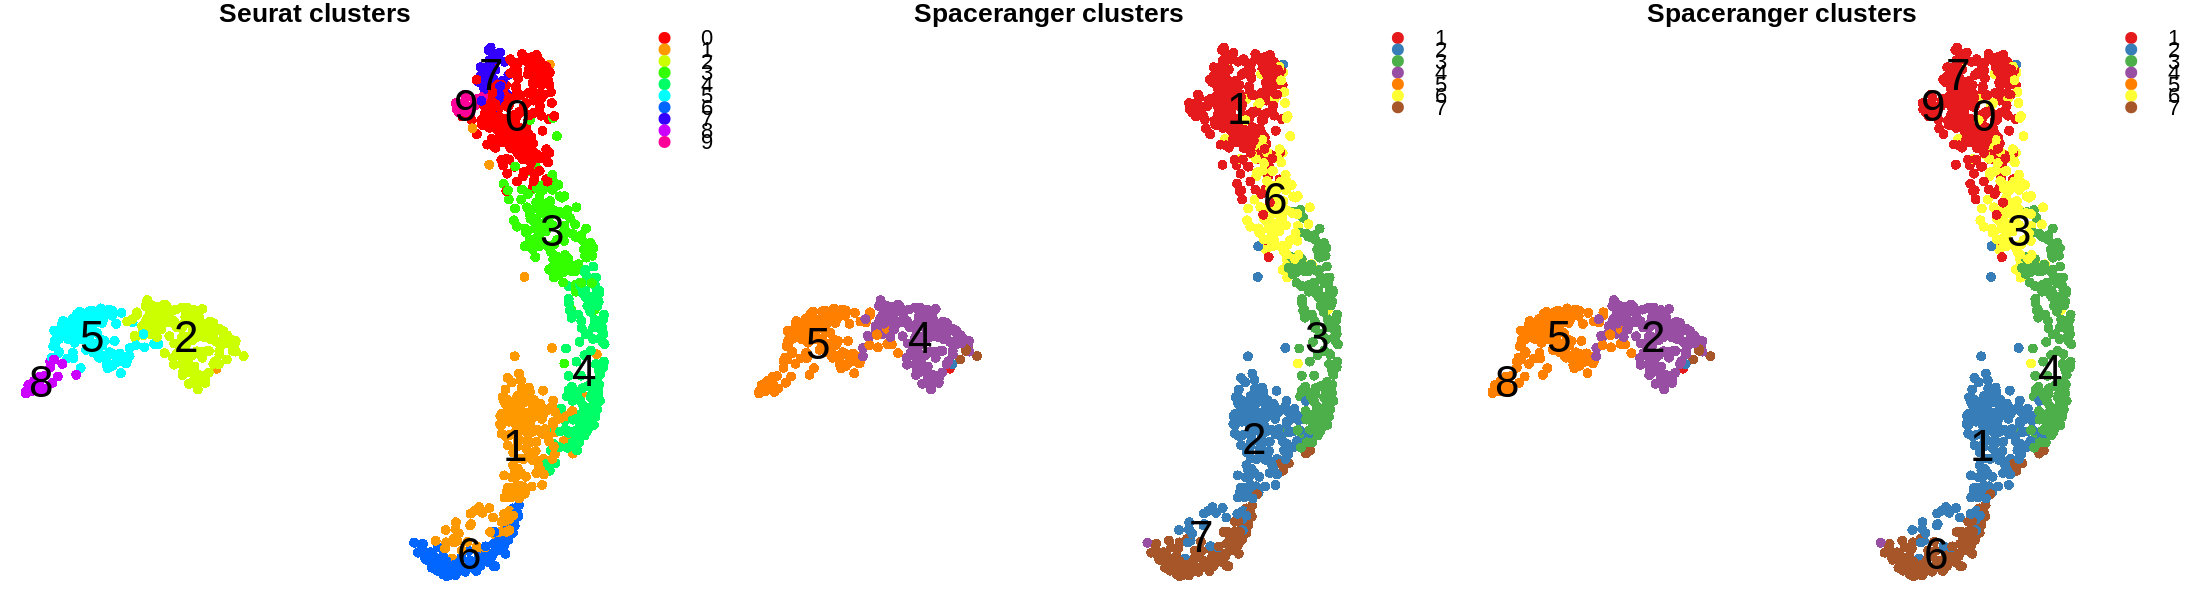

In [27]:
options(repr.plot.width = 11, repr.plot.height = 3, repr.plot.res = 200)
par(mfrow=c(1,3),mar=c(0.1,0.1,1,4),bty='n')
plotVisium(mob,z=mob$seurat_clusters,t='xy',pch=16,label.clusters = TRUE,cluster.lab.cex = 2,xlab='',ylab='',main='Seurat clusters')
plotVisium(mob@reductions$umap@cell.embeddings,z=mob$clusters,t='xy',pch=16,label.clusters = TRUE,
           cluster.lab.cex = 2,xlab='',ylab='',main='Spaceranger clusters')
# use different clusters for colours and labels
plotVisium(mob@reductions$umap@cell.embeddings,z=mob$clusters,t='xy',pch=16,label.clusters = as.character(mob$seurat_clusters)
           ,cluster.lab.cex = 2,xlab='',ylab='',main='Spaceranger clusters')

I'll use Seurat label transfer to deconvolve expression levels in all spots into signatures of unsupervised clustering. This analysis done only for demonstration purposes, in real life single cell reference should be used.

In [ ]:
mob.all = NormalizeData(mob.all)
mob.all = FindVariableFeatures(mob.all)
mob.all = ScaleData(mob.all, features = rownames(mob.all))
mob.all = RunPCA(mob.all, features = VariableFeatures(mob.all))

In [36]:
a = FindTransferAnchors(reference = mob, query = mob.all, verbose = FALSE)
p = TransferData(anchorset = a , refdata = mob$clusters, prediction.assay = TRUE,
                 weight.reduction =  mob.all[["pca"]], dims = 1:30, verbose = FALSE)


In [41]:
wghts = t(p@data[as.character(1:max(mob$clusters)),])
wghts[1:2,]

1 2 3 4 5 6 7
AAACAACGAATAGTTC-1 1 0 0 0 0 0 0
AAACAAGTATCTCCCA-1 1 0 0 0 0 0 0

parameters for pie charts of plotVisium are described in plotVisiumImg

In [44]:
?plotVisiumImg

plotVisiumImg             package:visutils             R Documentation

_P_l_o_t _V_i_s_i_u_m _s_a_m_p_l_e _o_n _t_o_p _o_f _H&_E

_D_e_s_c_r_i_p_t_i_o_n:

     Normally this function shouldn't be called directly. Use
     plotVisium instead

_U_s_a_g_e:

     plotVisiumImg(
       xy,
       img,
       scale.factor,
       cex = 1,
       col = "red",
       border = NA,
       spot.dist = NULL,
       img.alpha = 1,
       xlim = NULL,
       ylim = NULL,
       symmetric.lims = TRUE,
       xlab = "",
       ylab = "",
       pie.fraqs = NULL,
       pie.cols = NULL,
       pie.min.fraq = 0.05,
       ...
     )
     
_A_r_g_u_m_e_n_t_s:

pie.fraqs: if specified plots pies instead of simple cycles. Matrix
          with number of rows equal to the number of spots, and number
          of columns equal to pie pieces.

pie.cols: colors to be used for pie pieces (ncol(pie.fraqs) should be
          equal to length(pie.cols))

pie.min.fraq: all pieces with relative size less than ‘pie.min.fraq’
          will be discared

     ...: other parameters to be passed to ‘plot’ function

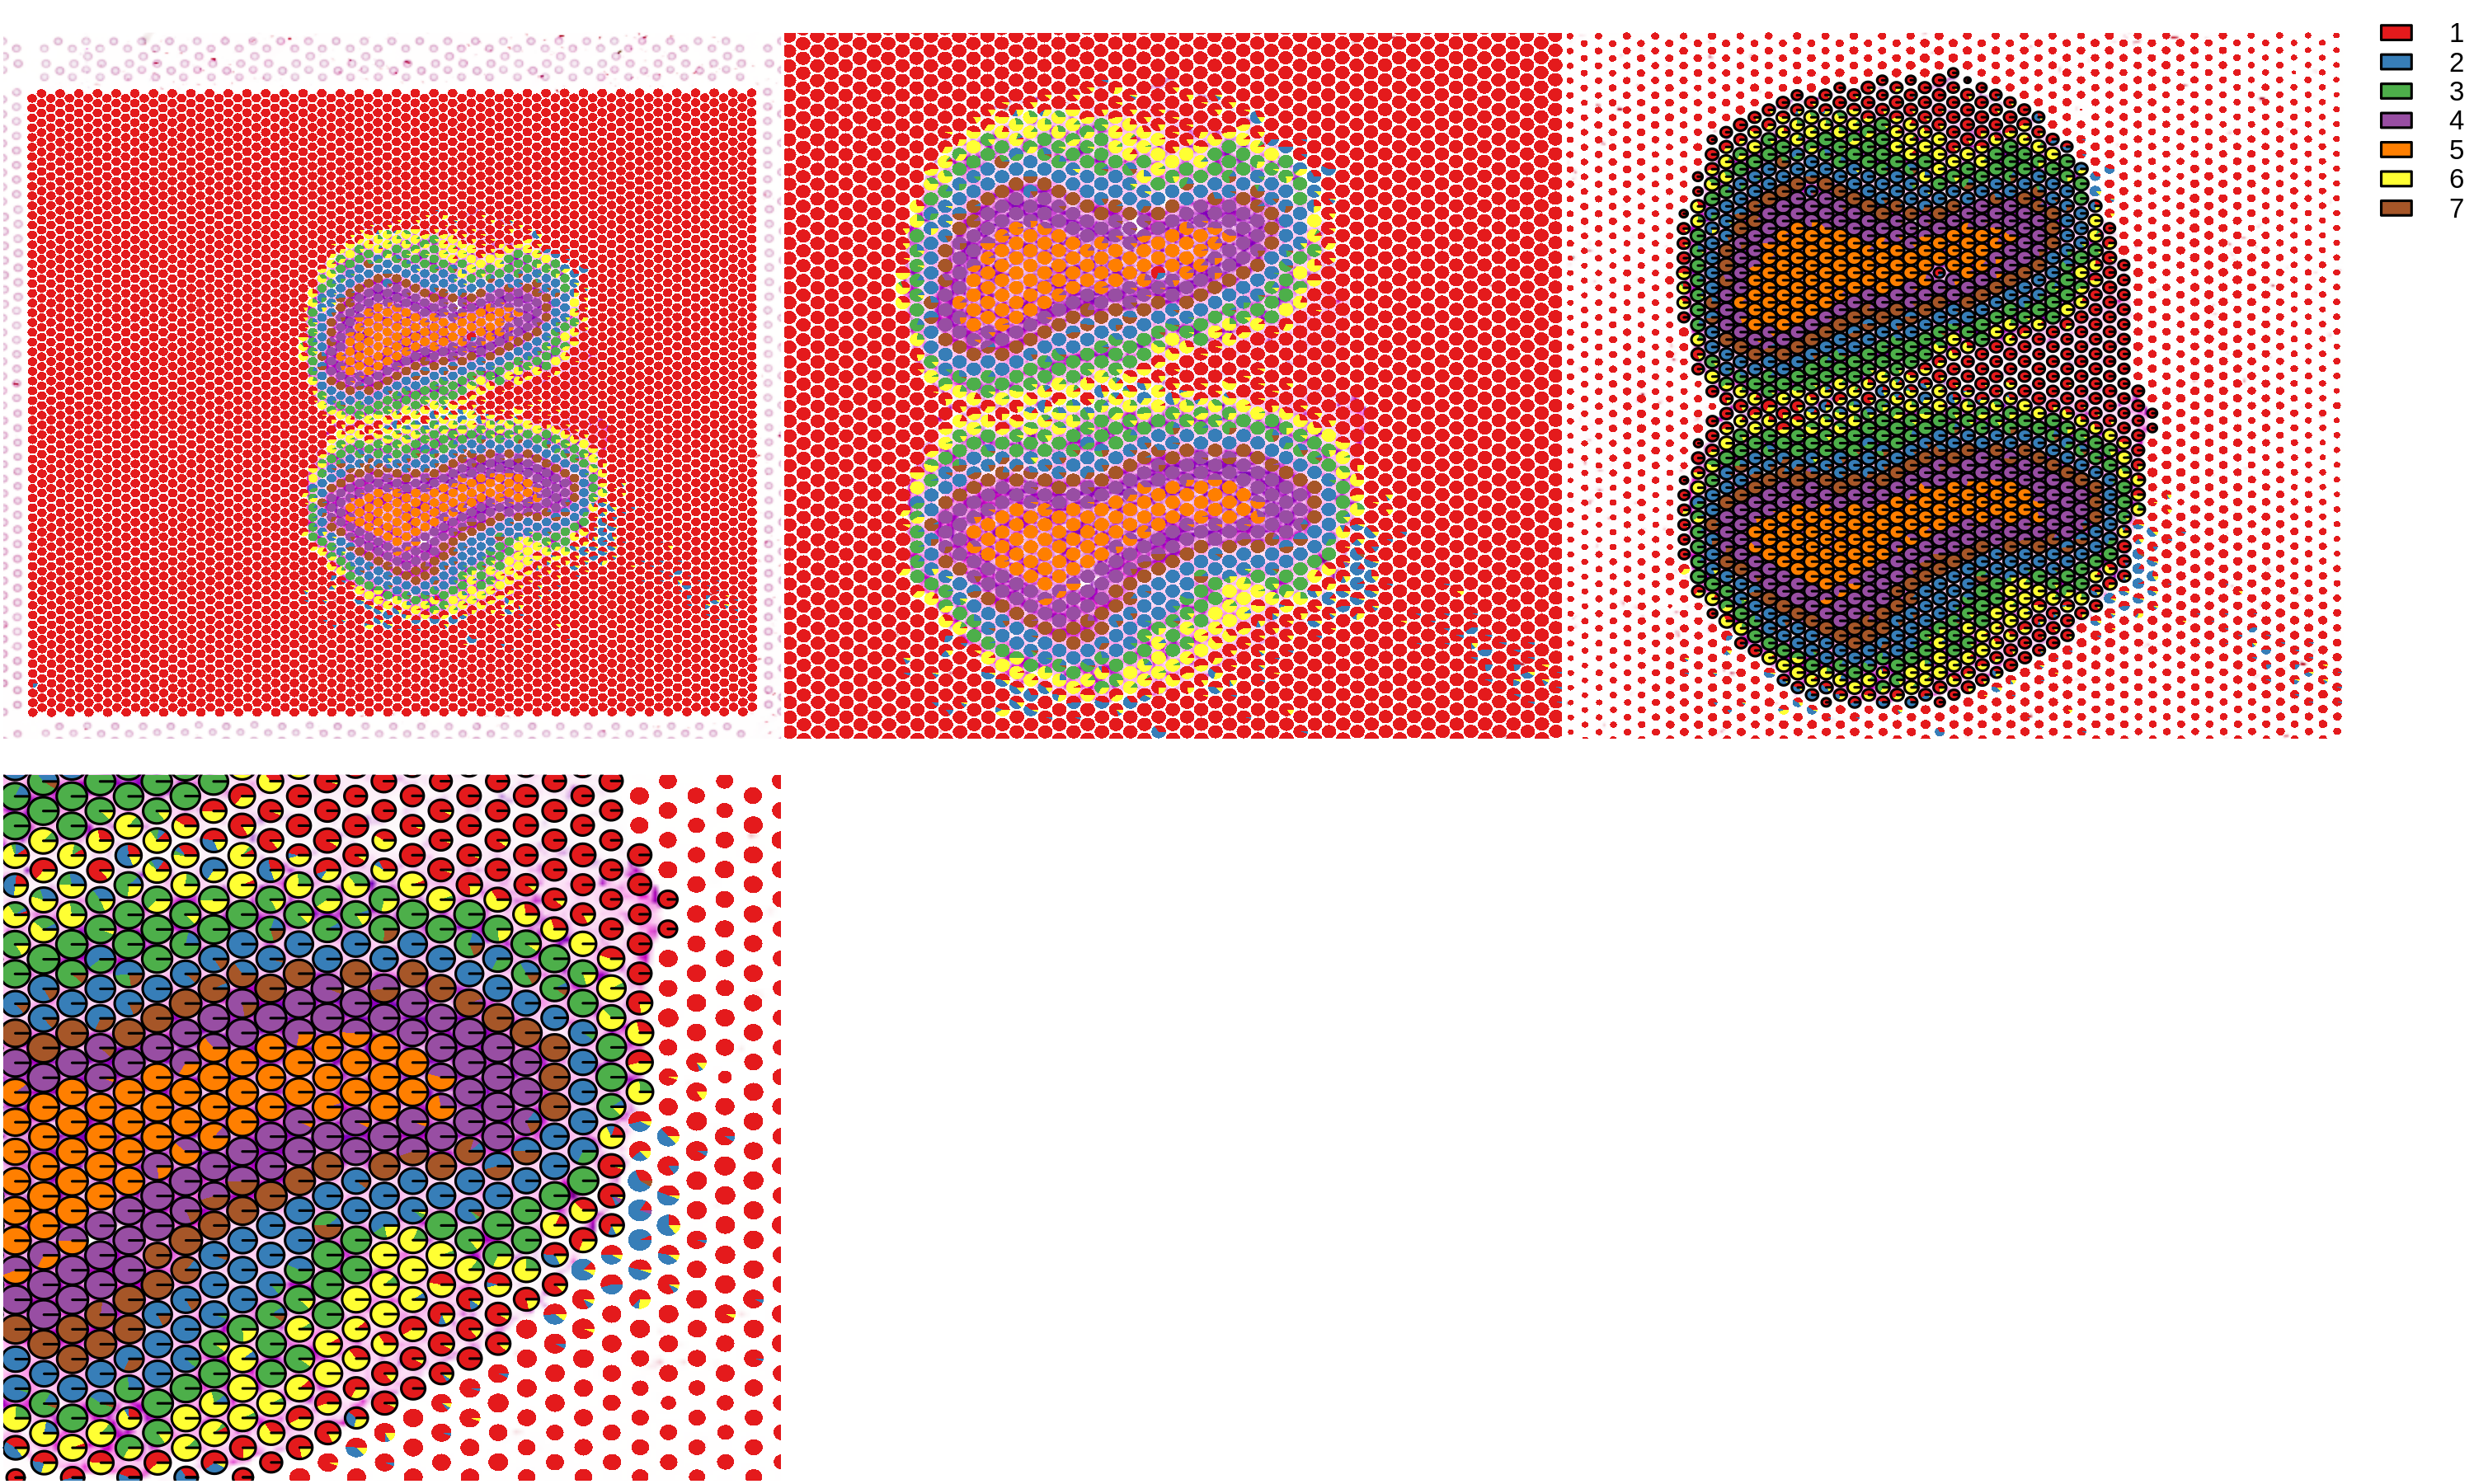

In [101]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 300)
par(mfrow=c(2,3),mar=c(0.1,0.1,1,0),oma=c(0,0,0,4),bty='n')
cl.col = char2col(mob$clusters)
plotVisium(mob.all,pie.fraqs=wghts,pie.col=cl.col,cex=0.9)
plotVisium(mob.all,pie.fraqs=wghts,pie.col=cl.col,cex=0.9,xlim=c(200,500),ylim=c(140,440))
plotVisium(mob.all,pie.fraqs=wghts,pie.col=cl.col,cex=scaleTo(log1p(mob.all$nCount_Spatial)),xlim=c(200,500),ylim=c(140,440),
          border=ifelse(mob.all$is.tissue==1,'black',NA))
legend(grconvertX(1,'nfc','user'),grconvertY(1,'nfc','user'),xpd=NA,fill=cl.col,legend=names(cl.col),bty='n')
plotVisium(mob.all,pie.fraqs=wghts,pie.col=cl.col,cex=scaleTo(log1p(mob.all$nCount_Spatial)),xlim=c(300,450),ylim=c(150,300),
          border=ifelse(mob.all$is.tissue==1,'black',NA))

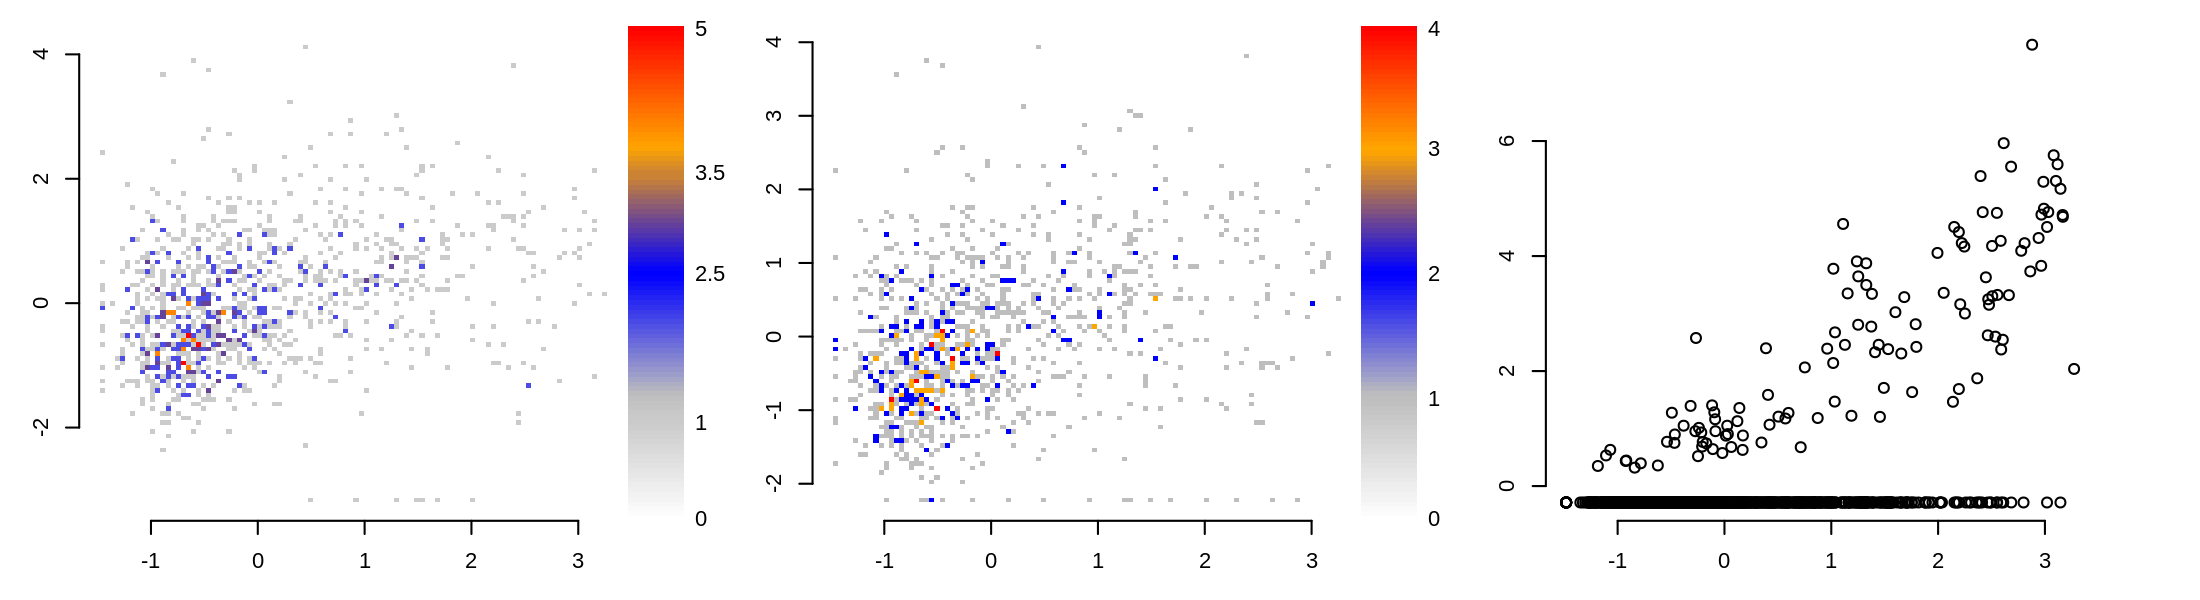

In [77]:
par(mfrow=c(1,3),mar=c(3,3,1,4),bty='n')
vg = VariableFeatures(mob)
plot.as.hm(mob@assays$Spatial@scale.data[vg[1],],mob@assays$Spatial@scale.data[vg[2],])
plot.as.hm(mob@assays$Spatial@scale.data[vg[1],],mob@assays$Spatial@scale.data[vg[3],])
plot(mob@assays$Spatial@scale.data[vg[1],],mob@assays$Spatial@scale.data[vg[40],])

In [ ]:
visutils::pl
# pie (using highly expressed genes)
# plot.as.hm

In [97]:
detach("package:visutils", unload=TRUE)

In [83]:
plotVisiumImg

function (xy, img, scale.factor, cex = 1, col = "red", border = NA, 
    spot.dist = NULL, img.alpha = 1, xlim = NULL, ylim = NULL, 
    symmetric.lims = TRUE, xlab = "", ylab = "", pie.fraqs = NULL, 
    pie.cols = NULL, pie.min.fraq = 0.05, ...) 
{
    if (is.null(spot.dist)) {
        spot.dist = min(dist(xy[, 4:5])) * 0.5
    }
    xlim. = range(xy$imagecol * scale.factor)
    ylim. = range(nrow(img) - xy$imagerow * scale.factor)
    if (symmetric.lims) {
        maxrange = max(xlim.[2] - xlim.[1], ylim.[2] - ylim.[1])
        xlim.[2] = xlim.[1] + maxrange
        ylim.[2] = ylim.[1] + maxrange
    }
    if (is.null(xlim)) 
        xlim = xlim.
    if (is.null(ylim)) 
        ylim = ylim.
    plot(1, t = "n", xlim = xlim, ylim = ylim, xlab = xlab, ylab = ylab, 
        ...)
    rasterImage(1 - (1 - img) * img.alpha, 1, 1, ncol(img), nrow(img))
    f = cex > 0
    if (any(cex > 0) & is.null(pie.fraqs)) 
        symbols(xy$imagecol[f] * scale.factor, nrow(img) - xy$imagerow[f] * 
            scale.factor, circles = cex[f] * spot.dist * scale.factor, 
            bg = col[f], inches = FALSE, fg = border[f], add = T)
    if (any(cex > 0) & !is.null(pie.fraqs)) {
        pie.fraqs = sweep(pie.fraqs, 1, apply(pie.fraqs, 1, sum), 
            "/")
        pie.fraqs[pie.fraqs < pie.min.fraq] = 0
        symbols.pie(x = xy$imagecol[f] * scale.factor, y = nrow(img) - 
            xy$imagerow[f] * scale.factor, r = cex[f] * spot.dist * 
            scale.factor, d = pie.fraqs[f, ], cols = pie.cols, 
            border = border[f])
    }
    invisible(data.frame(y = xy$imagecol * scale.factor, y = nrow(img) - 
        xy$imagerow * scale.factor))
}
<bytecode: 0x556f10e08308>
<environment: namespace:visutils>

In [67]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] SeuratObject_4.0.4 Seurat_4.1.0      

loaded via a namespace (and not attached):
  [1] Rtsne_0.15            colorspace_2.0-0      deldir_1.0-6         
  [4] ellipsis_0.3.1        ggridges_0.5.3        rprojroot_2.0.2      
  [7] IRdisplay_1.0         base64enc_